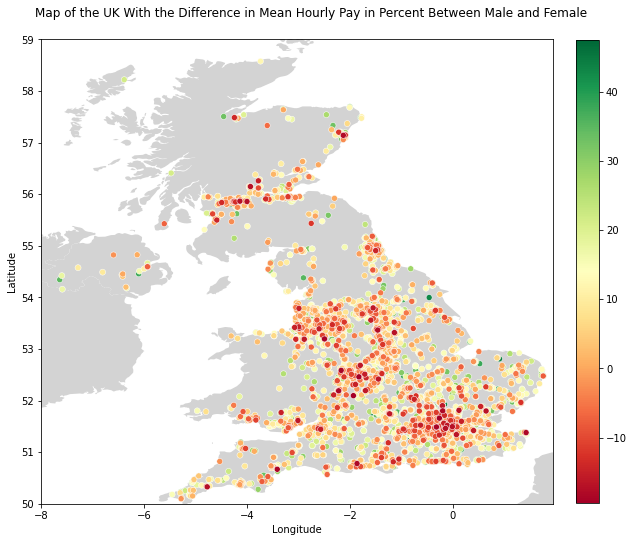

In [233]:
# Check UK Gender Pay Gap in the UK
# Datasets from:
# https://www.gov.uk/government/stat
# https://simplemaps.com/data/gb-cities
# https://www.freemaptools.com/download-uk-postcode-lat-lng.htm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Read the data.
df = pd.read_csv('uk-pay-gap.csv')
post_code_to_coordinates = pd.read_csv('ukpostcodes.csv')
city_to_coordinates = pd.read_csv('worldcities.csv')
city_to_coordinates_uk = city_to_coordinates[city_to_coordinates['country'] == 'United Kingdom']

# Extract area code from postcode.
grouped = df.groupby(df['PostCode'])
data = grouped['DiffMeanHourlyPercent'].mean().sort_values(ascending=False)
data_filtered = data[data.index.isin(post_code_to_coordinates['PostCode'])]

# Merge data to get region name and coordinates.
df_coordinates = data_filtered.to_frame().merge(post_code_to_coordinates, on='PostCode')

# Calculate quantiles and IQR.
Q1 = df_coordinates['DiffMeanHourlyPercent'].quantile(0.25)
Q3 = df_coordinates['DiffMeanHourlyPercent'].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values.
condition = ~((df_coordinates['DiffMeanHourlyPercent'] < (Q1 - 1.5 * IQR)) | (df_coordinates['DiffMeanHourlyPercent'] > (Q3 + 1.5 * IQR)))

# Filter our dataframe based on condition.
df_coordinates = df_coordinates[condition]

# Plot the data and country map.
fig, ax = plt.subplots(figsize=(10, 10))
countries = gpd.read_file('zip://./ukmap.zip').plot(color='lightgrey', ax=ax)
plot = sns.scatterplot(x = 'longitude', y = 'latitude', data = df_coordinates, hue = 'DiffMeanHourlyPercent', palette = 'RdYlGn', ax = ax, legend = False)
fig.suptitle('Map of the UK With the Difference in Mean Hourly Pay in Percent Between Male and Female', y = 0.87)
plot.set_xlabel('Longitude')
plot.set_ylabel('Latitude')
plot.set_xlim(-8, 1.95)
plot.set_ylim(50, 59)

norm = plt.Normalize(df_coordinates['DiffMeanHourlyPercent'].min(), df_coordinates['DiffMeanHourlyPercent'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])
plt.colorbar(sm,fraction=0.0415, pad=0.04)

In [167]:
summary_stats = df_coordinates[['DiffMeanHourlyPercent']].describe() \
                                                         .transpose() \
                                                         .rename({'DiffMeanHourlyPercent': 'Difference in Mean Hourly Pay in Percent'})
summary_stats # After removing outliers.

,count,mean,std,min,25%,50%,75%,max
Difference in Mean Hourly Pay in Percent,7300.0,14.010106,11.75486,-19.5,5.7,13.4,22.0,47.5
